# Dynamic-DeepHit

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
pip install deephit

     |████████████████████████████████| 347 kB 5.3 MB/s 
     |████████████████████████████████| 9.9 MB 57.1 MB/s 
     |████████████████████████████████| 22.3 MB 39.7 MB/s 
     |████████████████████████████████| 110.5 MB 1.3 kB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 14.8 MB 47.8 MB/s 
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lifelin

In [3]:
pip install tensorflow

In [4]:
#import tensorflow as tf
import numpy as np
from deephit import *


### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, num_layers, keep_prob, RNN_type, activation_fn): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer
        num_layers   : number of layers in MulticellRNN
        keep_prob    : keep probabilty [0, 1]  (if None, dropout is not employed)
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(num_layers):
        if RNN_type == 'GRU':
            cell = tf.contrib.rnn.GRUCell(num_units, activation=activation_fn)
        elif RNN_type == 'LSTM':
            cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn, state_is_tuple=True)
            # cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn)
        if not keep_prob is None:
            cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob) # state_keep_prob=keep_prob
        cells.append(cell)
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    return cell


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def create_concat_state(state, num_layers, RNN_type, BiRNN=None):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if BiRNN != None:
            if RNN_type == 'LSTM':
                tmp = tf.concat([state[0][i][1], state[1][i][1]], axis=1) ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = tf.concat([state[0][i], state[1][i]], axis=1) ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')
        else:
            if RNN_type == 'LSTM':
                tmp = state[i][1] ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = state[i] ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, w_reg=None, keep_prob=1.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out

In [5]:
def save_logging(dictionary, log_name):
    with open(log_name, 'w') as f:
        for key, value in dictionary.items():
            f.write('%s:%s\n' % (key, value))


def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data

In [6]:
import numpy as np
import random

##### USER-DEFINED FUNCTIONS
def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask1 is required to get the contional probability (to calculate the denominator part)
        mask1 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask

def f_get_minibatch(mb_size, x, x_mi, label, time, mask1, mask2, mask3):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb     = x[idx, :, :].astype(float)
    x_mi_mb  = x_mi[idx, :, :].astype(float)
    k_mb     = label[idx, :].astype(float) # censoring(0)/event(1,2,..) label
    t_mb     = time[idx, :].astype(float)
    m1_mb    = mask1[idx, :, :].astype(float) #fc_mask
    m2_mb    = mask2[idx, :, :].astype(float) #fc_mask
    m3_mb    = mask3[idx, :].astype(float) #fc_mask
    return x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb


def f_get_boosted_trainset(x, x_mi, time, label, mask1, mask2, mask3):
    _, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
    meas_time = np.concatenate([np.zeros([np.shape(x)[0], 1]), np.cumsum(x[:, :, 0], axis=1)[:, :-1]], axis=1)

    total_sample = 0
    for i in range(np.shape(x)[0]):
        total_sample += np.sum(np.sum(x[i], axis=1) != 0)

    new_label          = np.zeros([total_sample, np.shape(label)[1]])
    new_time           = np.zeros([total_sample, np.shape(time)[1]])
    new_x              = np.zeros([total_sample, np.shape(x)[1], np.shape(x)[2]])
    new_x_mi           = np.zeros([total_sample, np.shape(x_mi)[1], np.shape(x_mi)[2]])
    new_mask1          = np.zeros([total_sample, np.shape(mask1)[1], np.shape(mask1)[2]])
    new_mask2          = np.zeros([total_sample, np.shape(mask2)[1], np.shape(mask2)[2]])
    new_mask3          = np.zeros([total_sample, np.shape(mask3)[1]])

    tmp_idx = 0
    for i in range(np.shape(x)[0]):
        max_meas = np.sum(np.sum(x[i], axis=1) != 0)

        for t in range(max_meas):
            new_label[tmp_idx+t, 0] = label[i,0]
            new_time[tmp_idx+t, 0]  = time[i,0]

            new_x[tmp_idx+t,:(t+1), :] = x[i,:(t+1), :]
            new_x_mi[tmp_idx+t,:(t+1), :] = x_mi[i,:(t+1), :]

            new_mask1[tmp_idx+t, :, :] = f_get_fc_mask1(meas_time[i,t].reshape([-1,1]), num_Event, num_Category) #age at the measurement
            new_mask2[tmp_idx+t, :, :] = mask2[i, :, :]
            new_mask3[tmp_idx+t, :]    = mask3[i, :]

        tmp_idx += max_meas
        
    return(new_x, new_x_mi, new_time, new_label, new_mask1, new_mask2, new_mask3)


In [7]:
'''
Implemented: 02/12/2018
  > For survival analysis evaluation

First implemented by Kartik Ahuja
Modified by CHANGHEE LEE

Modifcation List:
	- 08/08/2018: Brier Score added
'''

import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G



### C(t)-INDEX CALCULATION
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)



In [8]:
import numpy as np
import tensorflow as tf
import random

from tensorflow.contrib.layers import fully_connected as FC_Net
from tensorflow.python.ops.rnn import _transpose_batch_time


#import utils_network as utils

_EPSILON = 1e-08



##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))

def get_seq_length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    tmp_length = tf.reduce_sum(used, 1)
    tmp_length = tf.cast(tmp_length, tf.int32)
    return tmp_length


class Model_Longitudinal_Attention:
    # def __init__(self, sess, name, mb_size, input_dims, network_settings):
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']
        self.x_dim_cont         = input_dims['x_dim_cont']
        self.x_dim_bin          = input_dims['x_dim_bin']

        self.num_Event          = input_dims['num_Event']
        self.num_Category       = input_dims['num_Category']
        self.max_length         = input_dims['max_length']

        # NETWORK HYPER-PARMETERS
        self.h_dim1             = network_settings['h_dim_RNN']
        self.h_dim2             = network_settings['h_dim_FC']
        self.num_layers_RNN     = network_settings['num_layers_RNN']
        self.num_layers_ATT     = network_settings['num_layers_ATT']
        self.num_layers_CS      = network_settings['num_layers_CS']

        self.RNN_type           = network_settings['RNN_type']

        self.FC_active_fn       = network_settings['FC_active_fn']
        self.RNN_active_fn      = network_settings['RNN_active_fn']
        self.initial_W          = network_settings['initial_W']
        
        self.reg_W              = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W'])
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W_out'])

        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')

            self.lr_rate     = tf.placeholder(tf.float32)
            self.keep_prob   = tf.placeholder(tf.float32)                                                      #keeping rate
            self.a           = tf.placeholder(tf.float32)
            self.b           = tf.placeholder(tf.float32)
            self.c           = tf.placeholder(tf.float32)

            self.x           = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])
            self.x_mi        = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])           
            #this is the missing indicator (including for cont. & binary) (includes delta)
            self.k           = tf.placeholder(tf.float32, shape=[None, 1])                                     #event/censoring label (censoring:0)
            self.t           = tf.placeholder(tf.float32, shape=[None, 1])


            self.fc_mask1    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for denominator
            self.fc_mask2    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for Loss 1
            self.fc_mask3    = tf.placeholder(tf.float32, shape=[None, self.num_Category])                     #for Loss 2

            
            seq_length     = get_seq_length(self.x)
            tmp_range      = tf.expand_dims(tf.range(0, self.max_length, 1), axis=0)
            
            self.rnn_mask1 = tf.cast(tf.less_equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32)            
            self.rnn_mask2 = tf.cast(tf.equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32) 
            
            
            ### DEFINE LOOP FUNCTION FOR RAW_RNN w/ TEMPORAL ATTENTION
            def loop_fn_att(time, cell_output, cell_state, loop_state):

                emit_output = cell_output 

                if cell_output is None:  # time == 0
                    next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                    next_loop_state = loop_state_ta
                else:
                    next_cell_state = cell_state
                    tmp_h = create_concat_state(next_cell_state, self.num_layers_RNN, self.RNN_type)

                    e = create_FCNet(tf.concat([tmp_h, all_last], axis=1), self.num_layers_ATT, self.h_dim2, 
                                           tf.nn.tanh, 1, None, self.initial_W, keep_prob=self.keep_prob)
                    e = tf.exp(e)

                    next_loop_state = (loop_state[0].write(time-1, e),                # save att power (e_{j})
                                       loop_state[1].write(time-1, tmp_h))  # save all the hidden states

                # elements_finished = (time >= seq_length)
                elements_finished = (time >= self.max_length-1)

                #this gives the break-point (no more recurrence after the max_length)
                finished = tf.reduce_all(elements_finished)    
                next_input = tf.cond(finished, lambda: tf.zeros([self.mb_size, 2*self.x_dim], dtype=tf.float32),  # [x_hist, mi_hist]
                                               lambda: inputs_ta.read(time))

                return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)


            
            # divide into the last x and previous x's
            x_last = tf.slice(self.x, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            x_last = tf.reshape(x_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            x_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x, reduction_indices=1)    #sum over time since all others time stamps are 0
            x_last = tf.slice(x_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            x_hist = self.x * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            x_hist = tf.slice(x_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            # do same thing for missing indicator
            mi_last = tf.slice(self.x_mi, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            mi_last = tf.reshape(mi_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            mi_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x_mi, reduction_indices=1)    #sum over time since all others time stamps are 0
            mi_last = tf.slice(mi_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            mi_hist = self.x_mi * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            mi_hist = tf.slice(mi_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            all_hist = tf.concat([x_hist, mi_hist], axis=2)
            all_last = tf.concat([x_last, mi_last], axis=1)


            #extract inputs for the temporal attention: mask (to incorporate only the measured time) and x_{M}
            seq_length     = get_seq_length(x_hist)
            rnn_mask_att   = tf.cast(tf.not_equal(tf.reduce_sum(x_hist, reduction_indices=2), 0), dtype=tf.float32)  #[mb_size, max_length-1], 1:measurements 0:no measurements
            

            ##### SHARED SUBNETWORK: RNN w/ TEMPORAL ATTENTION
            #change the input tensor to TensorArray format with [max_length, mb_size, x_dim]
            inputs_ta = tf.TensorArray(dtype=tf.float32, size=self.max_length-1).unstack(_transpose_batch_time(all_hist), name = 'Shared_Input')


            #create a cell with RNN hyper-parameters (RNN types, #layers, #nodes, activation functions, keep proability)
            cell = create_rnn_cell(self.h_dim1, self.num_layers_RNN, self.keep_prob, 
                                         self.RNN_type, self.RNN_active_fn)

            #define the loop_state TensorArray for information from rnn time steps
            loop_state_ta = (tf.TensorArray(size=self.max_length-1, dtype=tf.float32),  #e values (e_{j})
                             tf.TensorArray(size=self.max_length-1, dtype=tf.float32))  #hidden states (h_{j})
            
            rnn_outputs_ta, self.rnn_final_state, loop_state_ta = tf.nn.raw_rnn(cell, loop_fn_att)
            #rnn_outputs_ta  : TensorArray
            #rnn_final_state : Tensor
            #rnn_states_ta   : (TensorArray, TensorArray)

            rnn_outputs = _transpose_batch_time(rnn_outputs_ta.stack())
            # rnn_outputs =  tf.reshape(rnn_outputs, [-1, self.max_length-1, self.h_dim1])

            rnn_states  = _transpose_batch_time(loop_state_ta[1].stack())

            att_weight  = _transpose_batch_time(loop_state_ta[0].stack()) #e_{j}
            att_weight  = tf.reshape(att_weight, [-1, self.max_length-1]) * rnn_mask_att # masking to set 0 for the unmeasured e_{j}

            #get a_{j} = e_{j}/sum_{l=1}^{M-1}e_{l}
            self.att_weight  = div(att_weight,(tf.reduce_sum(att_weight, axis=1, keepdims=True) + _EPSILON)) #softmax (tf.exp is done, previously)

            # 1) expand att_weight to hidden state dimension, 2) c = \sum_{j=1}^{M} a_{j} x h_{j}
            self.context_vec = tf.reduce_sum(tf.tile(tf.reshape(self.att_weight, [-1, self.max_length-1, 1]), [1, 1, self.num_layers_RNN*self.h_dim1]) * rnn_states, axis=1)


            self.z_mean      = FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_mean1")
            self.z_std       = tf.exp(FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_std1"))

            epsilon          = tf.random_normal([self.mb_size, self.max_length-1, self.x_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
            self.z           = self.z_mean + self.z_std * epsilon

            
            ##### CS-SPECIFIC SUBNETWORK w/ FCNETS 
            inputs = tf.concat([x_last, self.context_vec], axis=1)


            #1 layer for combining inputs
            h = FC_Net(inputs, self.h_dim2, activation_fn=self.FC_active_fn, weights_initializer=self.initial_W, scope="Layer1")
            h = tf.nn.dropout(h, keep_prob=self.keep_prob)

            # (num_layers_CS-1) layers for cause-specific (num_Event subNets)
            out = []
            for _ in range(self.num_Event):
                cs_out = create_FCNet(h, (self.num_layers_CS), self.h_dim2, self.FC_active_fn, self.h_dim2, self.FC_active_fn, self.initial_W, self.reg_W, self.keep_prob)
                out.append(cs_out)
            out = tf.stack(out, axis=1) # stack referenced on subject
            out = tf.reshape(out, [-1, self.num_Event*self.h_dim2])
            out = tf.nn.dropout(out, keep_prob=self.keep_prob)

            out = FC_Net(out, self.num_Event * self.num_Category, activation_fn=tf.nn.softmax, 
                         weights_initializer=self.initial_W, weights_regularizer=self.reg_W_out, scope="Output")
            self.out = tf.reshape(out, [-1, self.num_Event, self.num_Category])


            ##### GET LOSS FUNCTIONS
            self.loss_Log_Likelihood()      #get loss1: Log-Likelihood loss
            self.loss_Ranking()             #get loss2: Ranking loss
            self.loss_RNN_Prediction()      #get loss3: RNN prediction loss

            self.LOSS_TOTAL     = self.a*self.LOSS_1 + self.b*self.LOSS_2 + self.c*self.LOSS_3 + tf.losses.get_regularization_loss()
            self.LOSS_BURNIN    = self.LOSS_3 + tf.losses.get_regularization_loss()

            self.solver         = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_TOTAL)
            self.solver_burn_in = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_BURNIN)


    ### LOSS-FUNCTION 1 -- Log-likelihood loss
    def loss_Log_Likelihood(self):
        sigma3 = tf.constant(1.0, dtype=tf.float32)

        I_1 = tf.sign(self.k)
        denom = 1 - tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True) # make subject specific denom.
        denom = tf.clip_by_value(denom, tf.cast(_EPSILON, dtype=tf.float32), tf.cast(1.-_EPSILON, dtype=tf.float32))

        #for uncenosred: log P(T=t,K=k|x,Y,t>t_M)
        tmp1 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp1 = I_1 * log(div(tmp1,denom))

        #for censored: log \sum P(T>t|x,Y,t>t_M)
        tmp2 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp2 = (1. - I_1) * log(div(tmp2,denom))

        self.LOSS_1 = - tf.reduce_mean(tmp1 + sigma3*tmp2)


    ### LOSS-FUNCTION 2 -- Ranking loss
    def loss_Ranking(self):
        sigma1 = tf.constant(0.1, dtype=tf.float32)

        eta = []
        for e in range(self.num_Event):
            one_vector = tf.ones_like(self.t, dtype=tf.float32)
            I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
            I_2 = tf.diag(tf.squeeze(I_2))
            tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

            R = tf.matmul(tmp_e, tf.transpose(self.fc_mask3)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

            diag_R = tf.reshape(tf.diag_part(R), [-1, 1])
            R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
            R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

            T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(self.t)) - tf.matmul(self.t, tf.transpose(one_vector))))
            # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

            T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

            tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), reduction_indices=1, keepdims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(tf.reshape(eta, [-1, self.num_Event]), reduction_indices=1, keepdims=True)

        self.LOSS_2 = tf.reduce_sum(eta) #sum over num_Events


    ### LOSS-FUNCTION 3 -- RNN prediction loss
    def loss_RNN_Prediction(self):
        tmp_x  = tf.slice(self.x, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)
        tmp_mi = tf.slice(self.x_mi, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)

        tmp_mask1  = tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.x_dim]) #for hisotry (1...J-1)
        tmp_mask1  = tmp_mask1[:, :(self.max_length-1), :] 

        zeta = tf.reduce_mean(tf.reduce_sum(tmp_mask1 * (1. - tmp_mi) * tf.pow(self.z - tmp_x, 2), reduction_indices=1))  #loss calculated for selected features.

        self.LOSS_3 = zeta

 
    def get_cost(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run(self.LOSS_TOTAL, 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})

    def train(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run([self.solver, self.LOSS_TOTAL], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb,
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def train_burn_in(self, DATA, MISSING, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (x_mi_mb)                 = MISSING

        return self.sess.run([self.solver_burn_in, self.LOSS_3], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def predict(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.out, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_z(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.z, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_rnnstate(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.rnn_final_state, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_att(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.att_weight, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_context_vec(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.context_vec, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def get_z_mean_and_std(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run([self.z_mean, self.z_std], feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

In [9]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split

#import import_data as impt

#from class_DeepLongitudinal import Model_Longitudinal_Attention

#from utils_eval             import c_index, brier_score
#from utils_log              import save_logging, load_logging
#from utils_helper           import f_get_minibatch, f_get_boosted_trainset

In [10]:
from sklearn.preprocessing import LabelEncoder as lbe


In [11]:
import pandas as pd
import numpy as np



##### USER-DEFINED FUNCTIONS
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        time: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['ID'])
    id_list  = pd.unique(df['ID'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['time'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['ID'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['time'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_  = pd.read_csv('/content/dataset_completo_modelli.txt' , sep = ' ')

    df_['time'] = df_['tstart']

    df_['label'] = df_['CVD1_COD_15']
    for i in np.unique(df_['ID']):
      if sum(df_.loc[df_.index[df_['ID']==i],'label'])>0:
        df_.loc[df_.index[df_['ID']==i],'label'] = 1
    df_['time_CVD1'] = np.float32(np.where( df_['time_CVD1'] == 'non evento' , 0 , df_['time_CVD1']))
    df_['tte'] = np.where(df_['label'] == 1 , df_['time_CVD1'], df_['end'] )

    df_[['SESSO']] = np.where(df_[['SESSO']]=='F',1,0) 
    df_[['anno_inizio_ARV']] = np.where(df_[['anno_inizio_ARV']]=='<=2007',1,0) 
    df_[['FDRn']] = np.where(df_[['FDRn']]=='MSM',1,0)
    df_[['HCV']] = np.float32(np.where(df_[['HCV']]=='non noto',0,df_[['HCV']]))
    df_[['HBV']] = np.float32(np.where(df_[['HBV']]=='non noto',0,df_[['HBV']]))

    bin_list           = ['SESSO' , 'RAZZA', 'anno_inizio_ARV' , 'FDRn' , 'HCV' , 'HBV']
    cont_list          = [ 'AGE_UPD' , "diabete_si_no" , 'ipert_si_no' , 'tumore_si_no'  , 'aids_si_no' , 'CD4' , "COLEST"  , 'VIREMIA' , 'Hb' , 'PLT' ,
                            'TRIG' , 'CREATININA' , 'ALT' , 'AST' , 'INI_time_exp' , "PI_time_exp" , 'NRTI_time_exp' , 'NNRTI_time_exp']
    feat_list          = cont_list + bin_list
    df_                = df_[['ID', 'tte', 'time', 'label']  + feat_list]
    df_ = df_.dropna()
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi




def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)



def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

### 1. Import Dataset
#####      - Users must prepare dataset in csv format and modify 'import_data.py' following our examplar 'PBC2'

In [12]:
data_mode                   = 'PBC2' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'PBC2':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard')
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    #pred_time = [2,5,8,11,15] # prediction time (in months)
    #eval_time = [2,5,8,11,15] # months evaluation time (for C-index and Brier-Score)
    pred_time = np.arange(0,16,1)
    eval_time = np.arange(0,16,1) # prediction time (in months)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1] 


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

### 2. Set Hyper-Parameters
##### - Play with your own hyper-parameters!

In [13]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32,

             'iteration_burn_in': 2000,
             'iteration':1000,

             'keep_prob': 0.65,
             'lr_train': 426*1e-6,

             'h_dim_RNN':75,
             'h_dim_FC' : 75,
             'num_layers_RNN':3,
             'num_layers_ATT':3,
             'num_layers_CS' :3,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :5.0,
             'beta'  :1.,
             'gamma' :3.
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
#save_logging(new_parser, log_name)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 3. Split Dataset into Train/Valid/Test Sets

In [14]:
### TRAINING-TESTING SPLIT
(tr_data, datate , tr_data_mi, data_mite, tr_time, timete , tr_label, labelte , 
 tr_mask1,mask1te , tr_mask2,mask2te, tr_mask3, mask3te) = train_test_split(data, data_mi,time, label, mask1, mask2, mask3 ,
                                                                            test_size=0.2  ,stratify = label ) 

#(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 #tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 
tr_data.shape
#if boost_mode == 'ON':
#    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

(3609, 456, 25)

In [15]:
a = data[0,0,1]
a


0.34103447768572615

In [16]:
def import_dataset_test( norm_mode = 'standard'):

    #df_= pd.read_csv('/content/database_time_dep_CM.csv')
    df_ = pd.read_csv('/content/dataset_completo_modelli_test.txt' ,index_col=0 , sep=',')
    
    df_['time'] = df_['tstart']

    df_['label'] = df_['CVD1_COD_15']
    for i in np.unique(df_['ID']):
      if sum(df_.loc[df_.index[df_['ID']==i],'label'])>0:
        df_.loc[df_.index[df_['ID']==i],'label'] = 1
    df_['time_CVD1'] = np.float32(np.where( df_['time_CVD1'] == 'non evento' , 0 , df_['time_CVD1']))
    df_['tte'] = np.where(df_['label'] == 1 , df_['time_CVD1'] - df_['time'], df_['end'] - df_['time'])

    df_[['SESSO']] = np.where(df_[['SESSO']]=='F',1,0) 
    df_[['anno_inizio_ARV']] = np.where(df_[['anno_inizio_ARV']]=='<=2007',1,0) 
    df_[['FDRn']] = np.where(df_[['FDRn']]=='MSM',1,0)
    df_[['HCV']] = np.float32(np.where(df_[['HCV']]=='non noto',0,df_[['HCV']]))
    df_[['HBV']] = np.float32(np.where(df_[['HBV']]=='non noto',0,df_[['HBV']]))

    bin_list           = ['SESSO' , 'RAZZA', 'anno_inizio_ARV' , 'FDRn' , 'HCV' , 'HBV']
    cont_list          = [ 'AGE_UPD' , "diabete_si_no" , 'ipert_si_no' , 'tumore_si_no'  , 'aids_si_no' , 'CD4' , "COLEST"  , 'VIREMIA' , 'Hb' , 'PLT' ,
                            'TRIG' , 'CREATININA' , 'ALT' , 'AST' , 'INI_time_exp' , "PI_time_exp" , 'NRTI_time_exp' , 'NNRTI_time_exp']
    feat_list          = cont_list + bin_list
    df_                = df_[['ID', 'tte', 'time', 'label']  + feat_list]
    df_ = df_.dropna()
    
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi





In [17]:
#(x_dimte, x_dim_contte, x_dim_binte), (datate, timete, labelte), (mask1te, mask2te, mask3te), (data_mite) = import_dataset_test('standard')

a=[1,2,3,4,5]
a.remove(2)
a

[1, 3, 4, 5]

### 4. Train the Networ

In [18]:
##### CREATE DYNAMIC-DEEPFHT NETWORK
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())
eval_time = np.arange(0,16,1)
 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%200 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5
c = []
cte = []
losss = []

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)
    losss.append(loss_curr)
   
        

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%(int((np.array(tr_data).shape[0]/mb_size))) == 0:   
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))     
        risk_alltr  = f_get_risk_predictions(sess, model, tr_data, tr_data_mi, pred_time, eval_time)
        risk_allte = f_get_risk_predictions(sess, model, datate, data_mite, pred_time, eval_time)
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            val_result1te = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_alltr[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                    val_result1te[k, t] = c_index(risk_allte[k][:, p, t], timete , (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
                val_final1te = val_result1te
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)
                val_final1te = np.append(val_final1te, val_result1te, axis=0)
        tmp_valid = np.mean(val_final1)
        tmp_validte = np.mean(val_final1te)
        print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))
        print( 'updated.... average c-index test set = ' + str('%.4f' %(tmp_validte)))
        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
        c.append(tmp_valid)
        cte.append(tmp_validte)

losss = np.array(losss)        
c  = np.array(c)      
cte  = np.array(cte)      

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
BURN-IN TRAINING ...
itr: 0200 | loss: 16.6448
itr: 0400 | loss: 13.5529
itr: 0600 | loss: 14.4986
itr: 0800 | loss: 10.0656
itr: 1000 | 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


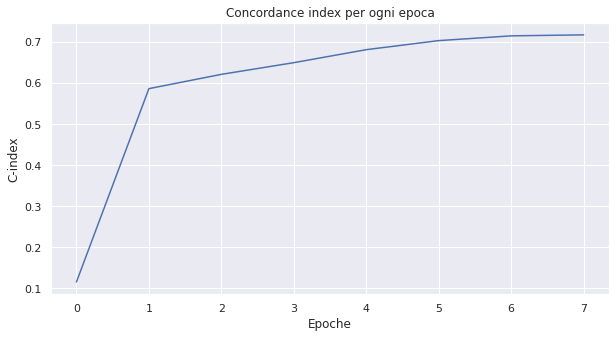

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(np.arange(len(c)),c )
plt.xlabel('Epoche')
plt.ylabel('C-index')
plt.title('Concordance index per ogni epoca')
plt.savefig('Epoc.png')

In [20]:

def _f_get_pred(sess, model, _data, _data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(_data))
    new_data_mi = np.zeros(np.shape(_data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(_data)[0], 1]), np.cumsum(_data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(_data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = _data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = _data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

In [21]:
## Curve e surv prob
pred_time = np.arange(0,16,1)
risk_all = _f_get_pred(sess, model, datate, data_mite, 0)
risk_all.shape



(903, 1, 26)

In [22]:
risk = np.zeros((903,25))
for j in range(903):
  for i in range(1,26):
    risk[j,i-1] = risk_all[j,0,i-1]-risk_all[j,0,i]

In [23]:
p = np.zeros((903,15 , 26))
def f_get_pred_mod(model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

for nn,pred_time in enumerate(np.linspace(1,15,15)):
  p[:,nn , :] = f_get_pred_mod(model , datate, data_mite , pred_time)[:,0,:]

In [24]:
ppp = model.predict(datate, data_mite,pred_time)

In [26]:
risk_all = risk_all[0]

In [27]:
import math

In [28]:
S = np.zeros((903,16))
S[:,0] = 1
for j in range(903):
  for i in range(0,15):
    S[j,i] = math.exp(-p[j,i,0]*np.linspace(0,15,16)[i])
S

array([[1.        , 0.93503029, 0.87203962, ..., 0.58459399, 0.56094472,
        0.        ],
       [1.        , 0.92286363, 0.87343136, ..., 0.58971254, 0.56623578,
        0.        ],
       [1.        , 0.90865502, 0.8023912 , ..., 0.5843208 , 0.5671688 ,
        0.        ],
       ...,
       [1.        , 0.89523381, 0.80730615, ..., 0.59429706, 0.5711828 ,
        0.        ],
       [1.        , 0.95017877, 0.90266624, ..., 0.58230872, 0.55858358,
        0.        ],
       [1.        , 0.91728825, 0.83627704, ..., 0.37556804, 0.34831515,
        0.        ]])

metrics



In [30]:

def _f_get_pred(sess, model, _data, _data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(_data))
    new_data_mi = np.zeros(np.shape(_data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(_data)[0], 1]), np.cumsum(_data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(_data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = _data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = _data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

In [32]:
p = np.zeros((903,16 , 26))
def f_get_pred_mod(model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

for nn,pred_time in enumerate(np.linspace(0,15,16)):
  p[:,nn , :] = f_get_pred_mod(model , datate, data_mite , pred_time)[:,0,:]

In [33]:
p.shape

(903, 16, 26)

In [34]:
S = np.zeros((903,16,26))
S[:,0,:] = 1
for i in range(1,16):
  for j in range(903):
    S[j,i,:] = S[j,i-1,:] * (1 - p[j,i,:])
i    

15

In [35]:
S[3,:,25]

array([1.        , 0.99339689, 0.98621116, 0.97761412, 0.96702309,
       0.95647802, 0.93768553, 0.91468269, 0.89224415, 0.87035606,
       0.84900492, 0.82817756, 0.80786112, 0.78804307, 0.76871119,
       0.74985355])

metrics



In [36]:
t = []
for i in range(903):
  m =(S[i,:,25])<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(0,15,16)[m][0])

t = np.array(t)
t

array([ 1.,  2.,  1.,  3.,  3.,  5.,  3.,  2.,  2.,  3.,  1.,  1.,  1.,
        2.,  1.,  5.,  1.,  2.,  1.,  1.,  3.,  4.,  1.,  3.,  2.,  5.,
        4.,  2.,  3.,  1.,  3.,  1.,  2.,  2.,  2.,  2.,  2.,  1.,  6.,
        2.,  3.,  2.,  4.,  4.,  3.,  1.,  2.,  2.,  2.,  2.,  4.,  3.,
        2.,  3.,  2.,  2.,  1.,  3.,  3.,  1.,  2.,  2.,  1.,  1.,  1.,
        1.,  2.,  1.,  1.,  4.,  2.,  1.,  2.,  1.,  1.,  1.,  3.,  3.,
        3.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  4.,  2.,  1.,
        2.,  1.,  2.,  3.,  2.,  3.,  2.,  2.,  2.,  1.,  3.,  9.,  1.,
        1.,  2.,  2.,  3.,  4.,  4.,  2.,  6.,  1.,  2.,  2.,  5.,  1.,
        2.,  2.,  2.,  5.,  5.,  2.,  2.,  2.,  1.,  4.,  3.,  3.,  2.,
        1.,  3.,  2.,  6.,  1.,  2.,  3.,  5.,  1.,  6.,  1.,  2.,  1.,
        2.,  2.,  4.,  1.,  2.,  1., 12.,  4.,  1.,  2.,  1.,  2.,  3.,
        2.,  5.,  2.,  2.,  2.,  2.,  4.,  2.,  1.,  2.,  1.,  4.,  3.,
        3.,  1.,  5.,  3.,  2.,  4.,  3.,  3.,  5.,  2.,  2.,  1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

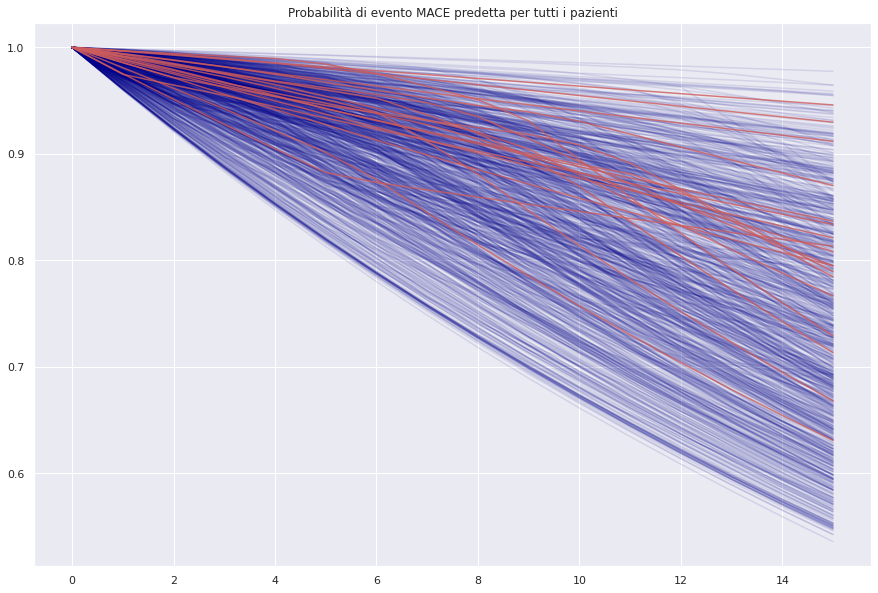

In [37]:
label = labelte
sum(label)
#
#cind = []
#risk = np.zeros(shape=(903  ,15))
#for t, t_time in enumerate(np.arange(0,15,1)):
#  eval_horizon = int(t_time)
#  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )
#
#risk = pd.DataFrame(risk)
sns.set(rc={'figure.figsize':(15,10)})
for i in range(903 ):
  if label[i] == 0:
    sns.lineplot(np.arange(0,16,1),S[i,:,25] , alpha = .1, color = 'darkblue')


for i in range(903  ):
  if label[i] == 1:
    sns.lineplot(np.arange(0,16,1),S[i,:,25] , alpha = .8, color = 'indianred')
plt.title('Probabilità di evento MACE predetta per tutti i pazienti')  
plt.savefig('sop_pred.png')


In [47]:
t = []
for i in range(903):
  m =(S[i,:,25])<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(1,15,16)[m][0])

t = np.array(t)
t
time_pred = t
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    

In [48]:
sum(labelte)

array([18.])

In [49]:
t = []
for i in range(903):
  m =S[i,:,25]<0.98
  if sum(m)== 0:
    t.append(15)
  else:
    t.append(np.linspace(1,15,16)[m][0])

t = np.array(t)
t
time_pred = t
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    
print(MSE_e)
print(MSE_a)
print(perc)



40.395444783349596
37.12762614627479
[0.16197183]


In [50]:
lab_pred = time_pred != 15.

In [51]:
for eva in range(26): 
  t = []
  for i in range(903):
    m =S[i,:,25]<0.98
    if sum(m)== 0:
      t.append(15)
    else:
      t.append(np.linspace(1,15,16)[m][0])

  t = np.array(t)
  t
  time_pred = t
  time_true = timete
  MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
  MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
  cnt = 0
  for i in range(903):
    if time_true[i] <= 15:
      if time_true[i] < time_pred[i]:
        cnt +=1
  perc = cnt/sum(time_true <= 15)    


  lab_pred = time_pred != 15.
  TP = sum(np.diag(np.multiply(lab_pred,labelte)))
  TN = sum(np.diag(labelte+lab_pred) == 0)
  FP = sum(lab_pred) - TP
  FN = sum(lab_pred==False) - TN
  print(eva)
  print("sens:"  + str(TP / (TP+FN)) + "acc:" + str((TP+TN)/(TP+TN+FP+FN))+ "sec:" + str((TN)/(TN+FP)) + ' ' + str(MSE_e) + ' ' +str(MSE_a) + ' ' + str(perc))
  

0
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
1
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
2
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
3
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
4
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
5
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
6
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
7
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
8
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
9
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 [0.16197183]
10
sens:1.0acc:0.019933554817275746sec:0.0 40.395444783349596 37.12762614627479 

In [52]:
pred_time = np.arange(0,16,1)

saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, datate, data_mite, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], timete , (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], timete , (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
    
c = np.mean(final1)

INFO:tensorflow:Restoring parameters from PBC2/model


In [53]:
import numpy as np


In [59]:
c_m = c
c

0.6123747068491803

In [61]:
def import_dataset_shuffle( data_s , data_mi_s  , col , norm_mode = 'standard'):
    
    data_s_mod = data_s.copy()
    data_mi_s_mod = data_mi_s.copy()
    data_mi_s = None
    data_s = None
    tempo  = ['time']
   
    bin_list           = ['SESSO' , 'RAZZA', 'anno_inizio_ARV' , 'FDRn' , 'HCV' , 'HBV']
    cont_list          = [ 'AGE_UPD' , "diabete_si_no" , 'ipert_si_no' , 'tumore_si_no'  , 'aids_si_no' , 'CD4' , "COLEST"  , 'VIREMIA' , 'Hb' , 'PLT' ,
                            'TRIG' , 'CREATININA' , 'ALT' , 'AST' , 'INI_time_exp' , "PI_time_exp" , 'NRTI_time_exp' , 'NNRTI_time_exp']
    feat_list  = tempo + cont_list + bin_list

    i = -1
    column = feat_list
    for j in range(len(column)):
      if column[j] == col:
        i = j
    s = np.random.permutation(range(3609))  
    for k in range(len(data_s_mod[0,:,0])):


      data_s_mod[:,k,i] = (data_s_mod[s,k,i])
      data_mi_s_mod[:,k,i] = (data_mi_s_mod[s,k,i])
    
    
    return data_s_mod , data_mi_s_mod





In [62]:
bin_list           = ['SESSO' , 'RAZZA', 'anno_inizio_ARV' , 'FDRn' , 'HCV' , 'HBV']
cont_list          = [ 'AGE_UPD' , "diabete_si_no" , 'ipert_si_no' , 'tumore_si_no'  , 'aids_si_no' , 'CD4' , "COLEST"  , 'VIREMIA' , 'Hb' , 'PLT' ,
                        'TRIG' , 'CREATININA' , 'ALT' , 'AST' , 'INI_time_exp' , "PI_time_exp" , 'NRTI_time_exp' , 'NNRTI_time_exp']
feat_list          = cont_list + bin_list
feat_list

['AGE_UPD',
 'diabete_si_no',
 'ipert_si_no',
 'tumore_si_no',
 'aids_si_no',
 'CD4',
 'COLEST',
 'VIREMIA',
 'Hb',
 'PLT',
 'TRIG',
 'CREATININA',
 'ALT',
 'AST',
 'INI_time_exp',
 'PI_time_exp',
 'NRTI_time_exp',
 'NNRTI_time_exp',
 'SESSO',
 'RAZZA',
 'anno_inizio_ARV',
 'FDRn',
 'HCV',
 'HBV']

In [63]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'AGE_UPD' )
data_imp

array([[[ 0.16153   , -0.9781949 , -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.39699   , -0.92979281, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.44353   , -0.90404626, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.00753   , -1.6033108 , -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.47912   , -1.59352713, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.24915   , -1.58013899, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [64]:
pred_time = np.arange(0,16,1)

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

#risk_all = f_get_risk_predictions(sess, model, data_imp, data_mite, pred_time, eval_time)
for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_age = np.mean(df1,axis =1)[0]
c_age

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.796189  ...      0.596372      0.595380
pred_time 1: event_1      0.521096     0.636973  ...      0.716022      0.716015
pred_time 2: event_1      0.510521     0.565325  ...      0.696995      0.696995
pred_time 3: event_1      0.519438     0.608492  ...      0.674244      0.674244
pred_time 4: event_1      0.559112     0.621849  ...      0.667951      0.667945
pred_time 5: event_1      0.615554     0.627628  ...      0.652586      0.652573
pred_time 6: event_1      0.519277     0.599600  ...      0.656371      0.656408
pred_time 7: event_1      0.658929     0.661052  ...      0.658481      0.658208
pred_time 8: event_1      0.688081     0.671431  ...      0.679811      0.679674
pred_time 9: event_1      0.682874     0.708431  ...      0.701556      0.701537
pred_time 10: event_1     0.730539     0

0.5223142696271633

In [65]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'COLEST')


In [66]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

    
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_col = np.mean(df1,axis =1)[0]
c_col

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.845809  ...      0.633598      0.632286
pred_time 1: event_1      0.511909     0.681802  ...      0.732945      0.732945
pred_time 2: event_1      0.539482     0.596718  ...      0.712832      0.712838
pred_time 3: event_1      0.547930     0.608401  ...      0.680425      0.680425
pred_time 4: event_1      0.613165     0.627759  ...      0.676522      0.676497
pred_time 5: event_1      0.625648     0.644507  ...      0.672860      0.672866
pred_time 6: event_1      0.535626     0.677433  ...      0.676714      0.676751
pred_time 7: event_1      0.685872     0.684286  ...      0.675944      0.675553
pred_time 8: event_1      0.713850     0.717678  ...      0.698242      0.698143
pred_time 9: event_1      0.730120     0.727654  ...      0.724964      0.724921
pred_time 10: event_1     0.750319     0

0.5729142013523507

In [67]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'VIREMIA')


In [68]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_vir = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.788874  ...      0.685263      0.684856
pred_time 1: event_1      0.507656     0.666079  ...      0.743911      0.743911
pred_time 2: event_1      0.512053     0.579837  ...      0.721830      0.721818
pred_time 3: event_1      0.525658     0.614697  ...      0.700867      0.700848
pred_time 4: event_1      0.515709     0.659379  ...      0.701624      0.701581
pred_time 5: event_1      0.652698     0.676490  ...      0.692886      0.692843
pred_time 6: event_1      0.472863     0.613367  ...      0.702499      0.702605
pred_time 7: event_1      0.719227     0.708889  ...      0.706440      0.706061
pred_time 8: event_1      0.733897     0.689461  ...      0.728123      0.727993
pred_time 9: event_1      0.665279     0.755353  ...      0.750942      0.750985
pred_time 10: event_1     0.775597     0

In [69]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'CD4')


In [70]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_cd4 = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.862198  ...      0.662198      0.659356
pred_time 1: event_1      0.626574     0.736083  ...      0.757576      0.757582
pred_time 2: event_1      0.633389     0.663277  ...      0.747566      0.747566
pred_time 3: event_1      0.631133     0.686667  ...      0.728489      0.728489
pred_time 4: event_1      0.571461     0.692735  ...      0.719044      0.719025
pred_time 5: event_1      0.693905     0.710655  ...      0.715072      0.715041
pred_time 6: event_1      0.429458     0.664371  ...      0.711206      0.711287
pred_time 7: event_1      0.725459     0.716267  ...      0.708798      0.708531
pred_time 8: event_1      0.739847     0.712605  ...      0.728340      0.728173
pred_time 9: event_1      0.696661     0.757162  ...      0.752884      0.752853
pred_time 10: event_1     0.776672     0

In [71]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'DIABETE')


In [72]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_dia = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.834127  ...      0.648340      0.646963
pred_time 1: event_1      0.827379     0.839904  ...      0.780916      0.780903
pred_time 2: event_1      0.831609     0.800995  ...      0.790069      0.790063
pred_time 3: event_1      0.812822     0.840936  ...      0.789474      0.789467
pred_time 4: event_1      0.528726     0.838089  ...      0.793241      0.793203
pred_time 5: event_1      0.853332     0.858784  ...      0.797833      0.797802
pred_time 6: event_1      0.175701     0.646637  ...      0.801730      0.801786
pred_time 7: event_1      0.850880     0.827264  ...      0.798640      0.798379
pred_time 8: event_1      0.837025     0.737754  ...      0.814154      0.814061
pred_time 9: event_1      0.647152     0.852592  ...      0.827987      0.827919
pred_time 10: event_1     0.864941     0

In [73]:
df1.shape

(16, 16)

In [74]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'SESSO')


In [75]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_sex = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.851367  ...      0.644178      0.642818
pred_time 1: event_1      0.839174     0.835626  ...      0.779364      0.779364
pred_time 2: event_1      0.778658     0.766008  ...      0.779017      0.778998
pred_time 3: event_1      0.777815     0.802251  ...      0.774201      0.774176
pred_time 4: event_1      0.561873     0.807446  ...      0.778545      0.778502
pred_time 5: event_1      0.820518     0.828808  ...      0.781685      0.781679
pred_time 6: event_1      0.244518     0.655913  ...      0.780010      0.780115
pred_time 7: event_1      0.808648     0.791792  ...      0.772358      0.772054
pred_time 8: event_1      0.805298     0.725497  ...      0.789592      0.789486
pred_time 9: event_1      0.663523     0.825396  ...      0.805745      0.805795
pred_time 10: event_1     0.840838     0

In [76]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'ipert_si_no')



In [77]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_ipert_si_no = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.773506  ...      0.622293      0.621184
pred_time 1: event_1      0.496257     0.656425  ...      0.730369      0.730357
pred_time 2: event_1      0.587144     0.630047  ...      0.726553      0.726540
pred_time 3: event_1      0.605149     0.655309  ...      0.703287      0.703275
pred_time 4: event_1      0.570050     0.681773  ...      0.703455      0.703436
pred_time 5: event_1      0.689178     0.699906  ...      0.701109      0.701097
pred_time 6: event_1      0.414420     0.673323  ...      0.712515      0.712559
pred_time 7: event_1      0.740519     0.730998  ...      0.711361      0.711119
pred_time 8: event_1      0.754790     0.725208  ...      0.731108      0.731009
pred_time 9: event_1      0.686691     0.757766  ...      0.747411      0.747392
pred_time 10: event_1     0.775543     0

In [78]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'tumore_si_no')


In [79]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_tumore_si_no = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.830101  ...      0.626252      0.625181
pred_time 1: event_1      0.389021     0.602809  ...      0.721774      0.721762
pred_time 2: event_1      0.462368     0.555887  ...      0.699812      0.699806
pred_time 3: event_1      0.522045     0.585646  ...      0.673096      0.673077
pred_time 4: event_1      0.524493     0.611358  ...      0.665016      0.664991
pred_time 5: event_1      0.607716     0.615898  ...      0.656036      0.656030
pred_time 6: event_1      0.483744     0.625288  ...      0.665847      0.665854
pred_time 7: event_1      0.669851     0.677600  ...      0.670942      0.670645
pred_time 8: event_1      0.706125     0.685507  ...      0.695995      0.695909
pred_time 9: event_1      0.691475     0.725984  ...      0.721464      0.721483
pred_time 10: event_1     0.745788     0

In [80]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'aids_si_no')


In [81]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_aids_si_no = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.793864  ...      0.641751      0.640553
pred_time 1: event_1      0.587161     0.713076  ...      0.755596      0.755584
pred_time 2: event_1      0.603301     0.644382  ...      0.742409      0.742396
pred_time 3: event_1      0.601418     0.665382  ...      0.717561      0.717554
pred_time 4: event_1      0.472564     0.666964  ...      0.705441      0.705422
pred_time 5: event_1      0.665228     0.679808  ...      0.697634      0.697603
pred_time 6: event_1      0.483094     0.590581  ...      0.699924      0.699998
pred_time 7: event_1      0.700247     0.687083  ...      0.696945      0.696684
pred_time 8: event_1      0.709244     0.662646  ...      0.715513      0.715407
pred_time 9: event_1      0.641185     0.734892  ...      0.733057      0.733063
pred_time 10: event_1     0.756343     0

In [82]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'Hb')



In [83]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_Hb = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.836566  ...      0.647646      0.646231
pred_time 1: event_1      0.570262     0.693595  ...      0.749905      0.749905
pred_time 2: event_1      0.619024     0.654057  ...      0.745226      0.745214
pred_time 3: event_1      0.604833     0.659769  ...      0.716152      0.716152
pred_time 4: event_1      0.586268     0.685029  ...      0.714408      0.714389
pred_time 5: event_1      0.690902     0.708726  ...      0.712838      0.712813
pred_time 6: event_1      0.446535     0.677414  ...      0.705614      0.705658
pred_time 7: event_1      0.733460     0.726646  ...      0.709090      0.708835
pred_time 8: event_1      0.754765     0.737271  ...      0.729569      0.729314
pred_time 9: event_1      0.727301     0.758137  ...      0.752940      0.752915
pred_time 10: event_1     0.777615     0

In [84]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'PLT')


In [85]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_PLT = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.775717  ...      0.623238      0.621997
pred_time 1: event_1      0.494669     0.648737  ...      0.739082      0.739089
pred_time 2: event_1      0.569570     0.613304  ...      0.731971      0.731958
pred_time 3: event_1      0.557131     0.628351  ...      0.704522      0.704522
pred_time 4: event_1      0.529787     0.653928  ...      0.696939      0.696945
pred_time 5: event_1      0.644425     0.667218  ...      0.688151      0.688133
pred_time 6: event_1      0.488760     0.626363  ...      0.693538      0.693594
pred_time 7: event_1      0.698754     0.691571  ...      0.688275      0.688040
pred_time 8: event_1      0.713799     0.674604  ...      0.709648      0.709518
pred_time 9: event_1      0.668210     0.736748  ...      0.734378      0.734372
pred_time 10: event_1     0.757479     0

In [86]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'PI_time_exp')


In [87]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_PI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.669219  ...      0.621025      0.619589
pred_time 1: event_1      0.438982     0.605006  ...      0.718771      0.718758
pred_time 2: event_1      0.572432     0.616641  ...      0.725225      0.725225
pred_time 3: event_1      0.582483     0.662454  ...      0.709685      0.709679
pred_time 4: event_1      0.553181     0.663190  ...      0.695511      0.695499
pred_time 5: event_1      0.657365     0.677570  ...      0.688915      0.688915
pred_time 6: event_1      0.342296     0.617106  ...      0.690702      0.690696
pred_time 7: event_1      0.702026     0.673282  ...      0.675547      0.675541
pred_time 8: event_1      0.691563     0.661196  ...      0.696901      0.696889
pred_time 9: event_1      0.623437     0.711655  ...      0.714638      0.714619
pred_time 10: event_1     0.727956     0

In [88]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'NRTI_time_exp')


In [89]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_NRTI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.549450  ...      0.621889      0.622723
pred_time 1: event_1      0.315073     0.561622  ...      0.729265      0.729265
pred_time 2: event_1      0.436181     0.525994  ...      0.711082      0.711076
pred_time 3: event_1      0.458013     0.526905  ...      0.673412      0.673419
pred_time 4: event_1      0.506440     0.567497  ...      0.660200      0.660213
pred_time 5: event_1      0.579750     0.592691  ...      0.656837      0.656855
pred_time 6: event_1      0.445797     0.637123  ...      0.662676      0.662620
pred_time 7: event_1      0.625573     0.634370  ...      0.653206      0.653082
pred_time 8: event_1      0.649743     0.650494  ...      0.667678      0.667697
pred_time 9: event_1      0.648739     0.658060  ...      0.684844      0.685073
pred_time 10: event_1     0.679410     0

In [90]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'NNRTI_time_exp')


In [91]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_NNRTI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.837700  ...      0.638718      0.635675
pred_time 1: event_1      0.710956     0.734725  ...      0.762243      0.762236
pred_time 2: event_1      0.591537     0.638912  ...      0.741528      0.741521
pred_time 3: event_1      0.575315     0.648209  ...      0.713701      0.713694
pred_time 4: event_1      0.505014     0.651142  ...      0.700358      0.700346
pred_time 5: event_1      0.646403     0.663525  ...      0.690795      0.690776
pred_time 6: event_1      0.415082     0.625088  ...      0.680549      0.680593
pred_time 7: event_1      0.688507     0.675724  ...      0.671923      0.671712
pred_time 8: event_1      0.705871     0.678324  ...      0.696734      0.696666
pred_time 9: event_1      0.652821     0.708470  ...      0.714147      0.714085
pred_time 10: event_1     0.729874     0

In [92]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'RAZZA')


In [93]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_RAZZA = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.831462  ...      0.646126      0.644791
pred_time 1: event_1      0.491550     0.654373  ...      0.740857      0.740857
pred_time 2: event_1      0.516417     0.586135  ...      0.722463      0.722457
pred_time 3: event_1      0.554900     0.643097  ...      0.709108      0.709108
pred_time 4: event_1      0.565074     0.656388  ...      0.700004      0.699973
pred_time 5: event_1      0.662357     0.683777  ...      0.699930      0.699917
pred_time 6: event_1      0.493589     0.631947  ...      0.698459      0.698509
pred_time 7: event_1      0.719665     0.708610  ...      0.699800      0.699539
pred_time 8: event_1      0.737109     0.707395  ...      0.722352      0.722234
pred_time 9: event_1      0.694051     0.748641  ...      0.745071      0.745052
pred_time 10: event_1     0.768522     0

In [94]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'anno_inizio_ARV')


In [95]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_anno_inizio_ARV = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.807077  ...      0.646322      0.645660
pred_time 1: event_1      0.605024     0.724377  ...      0.758953      0.758947
pred_time 2: event_1      0.714261     0.721938  ...      0.766127      0.766127
pred_time 3: event_1      0.697573     0.752037  ...      0.753474      0.753468
pred_time 4: event_1      0.564998     0.748812  ...      0.747206      0.747193
pred_time 5: event_1      0.757290     0.770873  ...      0.748242      0.748230
pred_time 6: event_1      0.311890     0.650538  ...      0.756359      0.756378
pred_time 7: event_1      0.787213     0.773882  ...      0.756595      0.756328
pred_time 8: event_1      0.790144     0.719506  ...      0.774518      0.774394
pred_time 9: event_1      0.657693     0.800752  ...      0.788636      0.788630
pred_time 10: event_1     0.817099     0

In [96]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'FDRn')

In [97]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_FDRn = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.860213  ...      0.647596      0.646138
pred_time 1: event_1      0.714018     0.785508  ...      0.768213      0.768213
pred_time 2: event_1      0.758541     0.754102  ...      0.771148      0.771148
pred_time 3: event_1      0.709084     0.745574  ...      0.744519      0.744513
pred_time 4: event_1      0.571370     0.760389  ...      0.745983      0.745983
pred_time 5: event_1      0.778937     0.790794  ...      0.752475      0.752475
pred_time 6: event_1      0.287051     0.653877  ...      0.760151      0.760133
pred_time 7: event_1      0.797650     0.782596  ...      0.754330      0.753995
pred_time 8: event_1      0.797421     0.727970  ...      0.772383      0.772228
pred_time 9: event_1      0.658233     0.807587  ...      0.789430      0.789350
pred_time 10: event_1     0.822975     0

In [98]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'HCV')


In [99]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_HCV = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.831689  ...      0.639191      0.637816
pred_time 1: event_1      0.828003     0.833198  ...      0.779774      0.779762
pred_time 2: event_1      0.825105     0.799179  ...      0.789288      0.789281
pred_time 3: event_1      0.795486     0.827101  ...      0.783888      0.783876
pred_time 4: event_1      0.510991     0.828140  ...      0.786948      0.786923
pred_time 5: event_1      0.835568     0.842511  ...      0.787029      0.787004
pred_time 6: event_1      0.203407     0.638845  ...      0.790982      0.791031
pred_time 7: event_1      0.840215     0.818220  ...      0.788381      0.788102
pred_time 8: event_1      0.828650     0.730627  ...      0.804380      0.804275
pred_time 9: event_1      0.640823     0.843892  ...      0.819286      0.819175
pred_time 10: event_1     0.855507     0

In [100]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'HBV')


In [101]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_HBV = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.833787  ...      0.645792      0.643668
pred_time 1: event_1      0.827095     0.839846  ...      0.780233      0.780221
pred_time 2: event_1      0.831638     0.800995  ...      0.789449      0.789443
pred_time 3: event_1      0.812862     0.840967  ...      0.788940      0.788934
pred_time 4: event_1      0.528543     0.837992  ...      0.792670      0.792632
pred_time 5: event_1      0.853429     0.858850  ...      0.797479      0.797454
pred_time 6: event_1      0.175095     0.646637  ...      0.801321      0.801376
pred_time 7: event_1      0.850699     0.827069  ...      0.798230      0.797957
pred_time 8: event_1      0.837068     0.737826  ...      0.813956      0.813863
pred_time 9: event_1      0.647345     0.852576  ...      0.827869      0.827795
pred_time 10: event_1     0.864964     0

In [102]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'CREATININA')

In [103]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_CREATININA = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.808382  ...      0.653213      0.652859
pred_time 1: event_1      0.580980     0.703220  ...      0.748670      0.748664
pred_time 2: event_1      0.623851     0.642921  ...      0.741875      0.741887
pred_time 3: event_1      0.596620     0.651759  ...      0.714303      0.714309
pred_time 4: event_1      0.570657     0.668942  ...      0.707209      0.707216
pred_time 5: event_1      0.670871     0.691020  ...      0.706731      0.706756
pred_time 6: event_1      0.440968     0.670088  ...      0.710852      0.710840
pred_time 7: event_1      0.730387     0.720882  ...      0.706949      0.706719
pred_time 8: event_1      0.748401     0.725594  ...      0.729935      0.729904
pred_time 9: event_1      0.702636     0.755647  ...      0.751897      0.751972
pred_time 10: event_1     0.775388     0

In [104]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'ALT')


In [105]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_ALT = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.835715  ...      0.642060      0.641719
pred_time 1: event_1      0.555801     0.706197  ...      0.751674      0.751674
pred_time 2: event_1      0.607781     0.647067  ...      0.742117      0.742111
pred_time 3: event_1      0.594527     0.673438  ...      0.722289      0.722289
pred_time 4: event_1      0.523598     0.702528  ...      0.724294      0.724269
pred_time 5: event_1      0.701020     0.719596  ...      0.720707      0.720695
pred_time 6: event_1      0.433791     0.632613  ...      0.716195      0.716264
pred_time 7: event_1      0.721235     0.712303  ...      0.713297      0.713018
pred_time 8: event_1      0.740084     0.707797  ...      0.735340      0.735173
pred_time 9: event_1      0.677559     0.760712  ...      0.756794      0.756726
pred_time 10: event_1     0.781992     0

In [106]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'AST')

In [107]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_AST = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.835885  ...      0.644695      0.643655
pred_time 1: event_1      0.507486     0.668709  ...      0.744618      0.744612
pred_time 2: event_1      0.588733     0.635161  ...      0.738971      0.738971
pred_time 3: event_1      0.600509     0.656341  ...      0.714489      0.714483
pred_time 4: event_1      0.555987     0.668978  ...      0.707557      0.707544
pred_time 5: event_1      0.666904     0.688374  ...      0.702282      0.702257
pred_time 6: event_1      0.461893     0.643088  ...      0.709046      0.709121
pred_time 7: event_1      0.731795     0.723747  ...      0.711795      0.711485
pred_time 8: event_1      0.747133     0.711333  ...      0.732659      0.732467
pred_time 9: event_1      0.684863     0.758253  ...      0.751407      0.751420
pred_time 10: event_1     0.776974     0

In [108]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'INI_time_exp')


In [109]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_INI_time_exp = np.mean(df1,axis =1)[0]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.832086  ...      0.624777      0.624424
pred_time 1: event_1      0.459056     0.634748  ...      0.738716      0.738710
pred_time 2: event_1      0.525204     0.601694  ...      0.725492      0.725485
pred_time 3: event_1      0.493889     0.572478  ...      0.675609      0.675591
pred_time 4: event_1      0.470941     0.608789  ...      0.674635      0.674616
pred_time 5: event_1      0.589807     0.609547  ...      0.659387      0.659356
pred_time 6: event_1      0.449678     0.568081  ...      0.660368      0.660455
pred_time 7: event_1      0.641642     0.642475  ...      0.658208      0.658158
pred_time 8: event_1      0.646270     0.624073  ...      0.666015      0.665996
pred_time 9: event_1      0.611639     0.675049  ...      0.686606      0.686556
pred_time 10: event_1     0.697497     0

In [110]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'TRIG')
data_imp

array([[[ 0.16153   , -0.59406353, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.39699   , -0.57887363, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.44353   , -0.54154165, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.00753   , -0.34329628, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.47912   , -0.24855057, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.24915   , -0.20349528, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [111]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_TRIG = np.mean(df1,axis =1)[0]
c_TRIG

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.839515  ...      0.638339      0.637270
pred_time 1: event_1      0.402007     0.612348  ...      0.702536      0.702543
pred_time 2: event_1      0.496618     0.576855  ...      0.690702      0.690702
pred_time 3: event_1      0.493948     0.560098  ...      0.653665      0.653659
pred_time 4: event_1      0.512599     0.594872  ...      0.655502      0.655502
pred_time 5: event_1      0.604086     0.624861  ...      0.657749      0.657749
pred_time 6: event_1      0.531636     0.622966  ...      0.662831      0.662875
pred_time 7: event_1      0.663514     0.658330  ...      0.656216      0.655949
pred_time 8: event_1      0.685291     0.658474  ...      0.679643      0.679451
pred_time 9: event_1      0.682359     0.709405  ...      0.708556      0.708562
pred_time 10: event_1     0.732820     0

0.5726066740545203

In [112]:
data_imp , data_impte = import_dataset_shuffle(tr_data, tr_data_mi,'NNRTI_time_exp')
data_imp

array([[[ 0.16153   , -0.59406353, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.39699   , -0.57887363, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.44353   , -0.54154165, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.00753   , -0.34329628, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.47912   , -0.24855057, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.24915   , -0.20349528, -0.21499781, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [113]:

risk_all = f_get_risk_predictions(sess, model, data_imp, data_impte, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t],tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')
c_NRTTI_time_exp = np.mean(df1,axis =1)[0]
c_NRTTI_time_exp

--------------------------------------------------------
- C-INDEX: 
                       eval_time 0  eval_time 1  ...  eval_time 14  eval_time 15
pred_time 0: event_1     -1.000000     0.766360  ...      0.628510      0.628600
pred_time 1: event_1      0.420608     0.609920  ...      0.730413      0.730425
pred_time 2: event_1      0.495549     0.570182  ...      0.713825      0.713819
pred_time 3: event_1      0.523980     0.618854  ...      0.693035      0.693041
pred_time 4: event_1      0.500448     0.644606  ...      0.698050      0.698050
pred_time 5: event_1      0.643629     0.658222  ...      0.690782      0.690782
pred_time 6: event_1      0.429568     0.597945  ...      0.681685      0.681679
pred_time 7: event_1      0.663514     0.644918  ...      0.662608      0.662372
pred_time 8: event_1      0.669250     0.636973  ...      0.680667      0.680586
pred_time 9: event_1      0.630185     0.687700  ...      0.701450      0.701562
pred_time 10: event_1     0.708400     0

0.5458664121249924

In [114]:
c_m = np.mean(c)

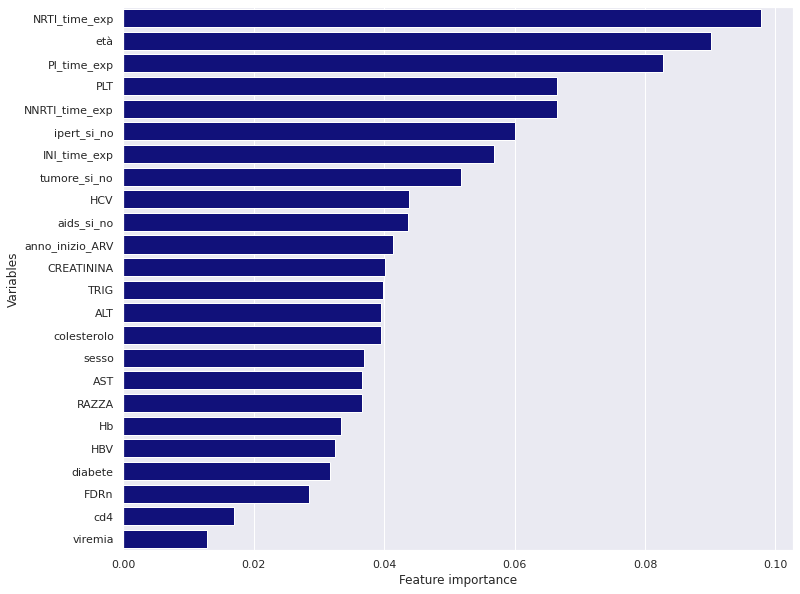

In [115]:
sns.set(rc={'figure.figsize':(12,10)})
d = pd.DataFrame({'Variables':['età' , 'cd4' , 'colesterolo'  , 'diabete' , 'sesso' , 'viremia'   , 'ipert_si_no' , 'tumore_si_no'  , 
                             'aids_si_no' , 'Hb' , "PI_time_exp" , 'NRTI_time_exp' , 'NNRTI_time_exp',
                              'RAZZA', 'anno_inizio_ARV' , 'FDRn' , 'HCV' , 'HBV' , 'PLT' ,  'TRIG' , 'CREATININA' , 'ALT' , 
                             'AST' ,'INI_time_exp' ], 
                  'Feature importance':[c_m-c_age , c_m-c_cd4 , c_m-c_col , c_m-c_dia , c_m-c_sex , c_m-c_vir,
                           c_m-c_ipert_si_no , c_m-c_tumore_si_no , c_m-c_aids_si_no ,
                            c_m-c_Hb, c_m-c_PI_time_exp , c_m-c_NRTI_time_exp , c_m-c_NRTTI_time_exp , 
                            c_m-c_RAZZA , c_m-c_anno_inizio_ARV ,c_m-c_FDRn , c_m-c_HCV ,  c_m-c_HBV ,
                            c_m-c_PLT , c_m-c_TRIG , c_m-c_CREATININA , c_m-c_ALT , c_m-c_AST , c_m-c_INI_time_exp]})
d.sort_values(by=['Feature importance'],
                               ascending=False, inplace=True)
sns.barplot(y = 'Variables',x= 'Feature importance',data=d, color= 'darkblue', orient= 'h')
plt.savefig('feature_imp1.png')

In [116]:
label = labelte
sum(label)
p = model.predict( datate , data_mite)

p.shape
cind = []
risk = np.zeros(shape=(903  ,3000))
for t, t_time in enumerate(np.linspace(1,15,3000 )):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )

risk = pd.DataFrame(risk)


In [117]:
time_pred = np.zeros(903)
t = np.linspace(0,15,3000)
for k in range(903):
  if sum((risk.loc[k,:]>0.02))>0:
    time_pred[k] = t[(risk.loc[k,:]>0.02)][0]
  else:
    time_pred[k] = 15


In [118]:
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    

In [119]:
print(MSE_e)
print(MSE_a)
print(perc)



91.1261733716893
73.23293911490879
[0.]


In [120]:
lab_pred = time_pred != 15.

In [121]:
TP = sum(np.diag(np.multiply(lab_pred,labelte)))
TN = sum(np.diag(labelte+lab_pred) == 0)
FP = sum(lab_pred) - TP
FN = sum(lab_pred==False) - TN
print("sens:"  + str(TP / (TP+FN)))
print("acc:" + str((TP+TN)/(TP+TN+FP+FN)))

print("sec:" + str((TN)/(TN+FP)))
print(str(TP)+"|"+str(FN))
print(str(FP)+"|"+str(TN))


sens:1.0
acc:0.019933554817275746
sec:0.0
18.0|0
885.0|0
